## Requirements

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import time
import timeit

## Introduction

Microbenchmarks are nt always as straightforward as `%timeit` or `timeit.repeat(...)` leads you to believe.  In this notebook you will explore some of the pitfalls you may encounter when executing and interpreting microbenchmarks.

## Understanding `timeit`

It is quite important to properly understand how `%timeit` and especially `timeit.timeit(...)` and `timeit.repeat(...)` work, becourse this will influence whether or not you can make sense of the results.

The number of expression evaluations is determined by two numbers:
* `number`
* `repeat`

### `timeit` magic

In [21]:
%timeit np.zeros((100, 100))

1.27 μs ± 12.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In the example above, `repeat` is equal to 7 (that is the default) and `number` is equal to 1 million (this may be different, it depends on the runtime of the expression and is determined at runtime when using `%timeit`).  In total, 7 million 2D arrays have been created for this microbenchmark.

The mean value and the standard deviation are computed using the runtime of these 7 repetitions of the benchmark.  This gives you some idea about the spread of the run times.  For each repeat, the time is the average of the number of runs, so 1 million.

For the `%timeit` magic, you can control the number of repeats via the `-r` option, and the number of loops via the `-n` option.

In [22]:
%timeit -r 100 -n 1_000 np.zeros((100, 100))

1.25 μs ± 126 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)


This applies to both the line magic `%timeit` and the cell magic `%%timit`.

### `timeit` module

In fact, you can use similar functionality to time your code in Python scripts, so the use of `timeit` is not restricted to notebooks.

The function `timeit.repeat(...)` is the most similar to the magic, but it has an additional feature.  It has an optional `setup` parameter.  This is a string or a callable that will be executed before each repeat, but its execution time is not taking into account for the benchmakr.

In [28]:
timeit.repeat(
    'x **= 2; print(x)',
    setup='x = 5',
    repeat=3,
    number=4,
)

25
625
390625
152587890625
25
625
390625
152587890625
25
625
390625
152587890625


[0.00011249600038354401, 2.267500030939118e-05, 2.1125999865034828e-05]

You will notice that the expression you are timing modifies the variable `x`, that this expression is evaluated 4 times, so the last values printed is $5^5$ and that this is repeated 3 times, each time starting from `x` is equal to 5.

## Warm up

When performing benchmarks, you should realize that hardware plays an important role, even beyond the trivial.  Consider the folloing series of benchmarks.

In [155]:
A = np.random.uniform(0.0, 1.0, size=(50, 50))
benchmark_results = []
for _ in range(5):
    times = timeit.repeat(lambda: A**2, repeat=5, number=100_000)
    benchmark_results.append(times)

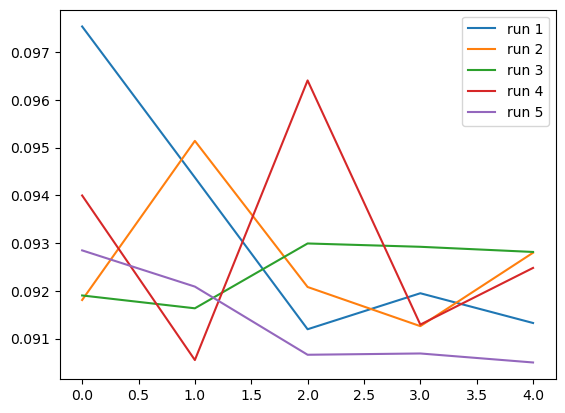

In [156]:
x = list(range(5))
for i, times in enumerate(benchmark_results):
    plt.plot(x, times, label=f'run {i + 1}')
plt.legend();

In [153]:
A = np.random.uniform(0.0, 1.0, size=(50, 50))
benchmark_results = []
for _ in range(5):
    times = timeit.repeat(lambda: A**2, repeat=5, number=100_000)
    benchmark_results.append(times)

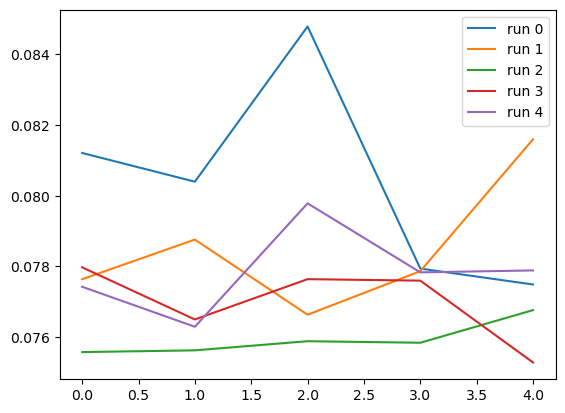

In [154]:
x = list(range(5))
for i, times in enumerate(benchmark_results):
    plt.plot(x, times, label=f'run {i + 1}')
plt.legend();

When the CPU is idle, its clock frequency is lowered to conserve energy (energy is proportional to the cube of the frequency).  Once the first repeat of the first benchmark starts, the CPU's frequency is ramped up, but not as fast as you might wish.  Hence the first repeat in the first call to `timeit.repeat()` has an unexpectedly high value.

Depending on the energy saving settings of the computer, it takes some time for the CPU's frequency to go down again when it is idle, so the second time you run the benchmarks, you don't see the outlier anymore.

In addition, you notice quite some jitter on the results.  This is caused by other processes on your computer "stealing time" from your process.  Typically, more than 100 processes are running on your computer, most of them idling, but occasionally getting some CPU time nevertheless.

## What are you measuring?

The following function implements an in-place element-wise matrix square.  It modifies its argument as illustrated below.

In [3]:
def square_matrix(A):
    A **= 2

In [47]:
A = np.array([
    [1, 2],
    [3, 4],
])

In [37]:
square_matrix(A)
A

array([[ 1,  4],
       [ 9, 16]])

You can also define a function to fill a given matrix with new random values.  *Note that this is also done in-place.*

In [8]:
def init_matrix(A):
    A[:, :] = np.random.uniform(0.0, 1.0, size=A.shape)

In [44]:
def create_init_function(rows, cols):
    A = np.random.uniform(0.0, 1.0, size=(rows, cols))
    def init_matrix(X):
        nonlocal A
        X[:, :] = A[:, :]
    return init_matrix

In [45]:
i1 = create_init_function(2, 2)

In [50]:
C = np.empty((2, 2))
i1(C)
C

array([[0.34512971, 0.66574136],
       [0.67641712, 0.3660836 ]])

In [51]:
C = np.empty((2, 2))
i1(C)
C

array([[0.34512971, 0.66574136],
       [0.67641712, 0.3660836 ]])

Next, you can execute the following function to benchmark this simple function.

In [4]:
rows, cols = 50, 50

In [86]:
def benchmark(func, setup_creator, rows, cols):
    setup = setup_creator(rows, cols)
    figure, axes = plt.subplots(1, 2, figsize=(12, 6))
    A = np.empty((rows, cols))
    def run(repeat, number, axis):
        times = [t/number for t in timeit.repeat(
            lambda: func(A),
            setup=lambda: setup(A),
            repeat=repeat,        
            number=number)]

        axes[axis].hist(times, bins=20)
        axes[axis].set_xscale('log')
        axes[axis].set_yscale('log')
        axes[axis].set_title(f'{repeat=}, {number=}')
        print(f'{repeat=}, {number=}: {min(times)} - {max(times)}')
    run(250, 100, axis=0)
    run(25_000, 1, axis=1)
    plt.tight_layout()
    plt.show()

repeat=250, number=100: 6.828099958511303e-07 - 2.7317199965182225e-06
repeat=25000, number=1: 6.640002538915724e-07 - 0.00045775600028719055


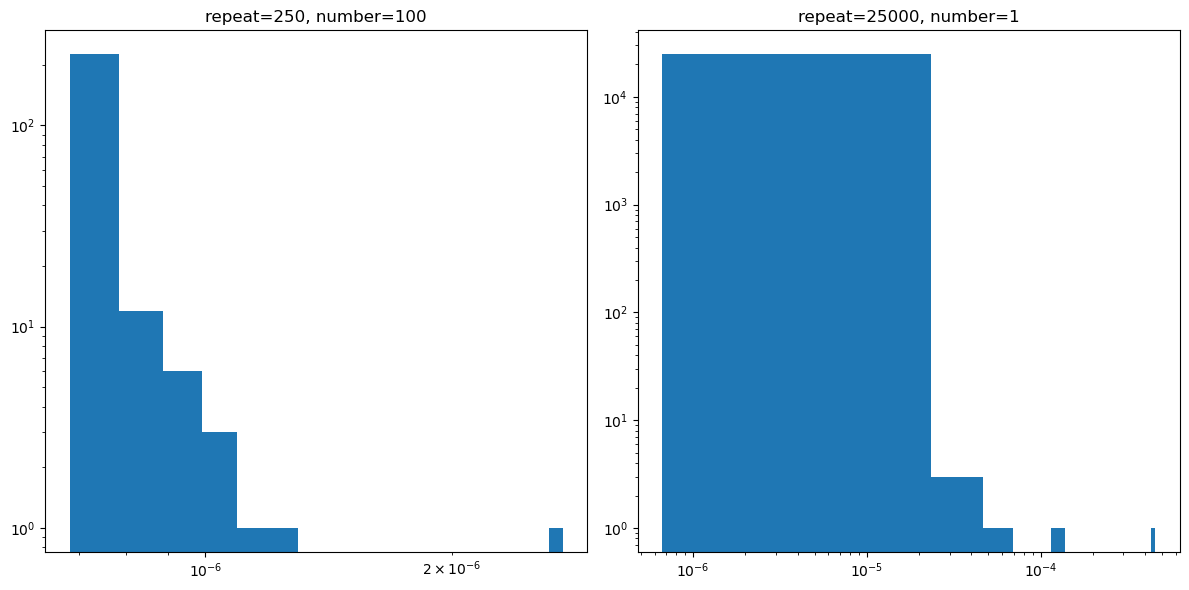

In [87]:
benchmark(square_matrix, create_init_function, 50, 50)

Note that the only difference between the two benchmark runs is the `repeat` and the `number`, and that the total number of evaluations is the same.  Yet the result are quite different.  If the setup function is called before executing each (single) loop, the runtimes are much larger.

Also notice that although the number of computations for both benchmarks are the same, the second one where `repeat` is large takes much longer.  The reason for this is that the setup function is called many times, and it takes a long time to initialize a random array.  However, this is not included in the benchmark result.

You can redo the benchmark for larger 2D arrays, so increasing the number of rows and columns.

repeat=250, number=100: 4.648914000426885e-05 - 7.636342000296282e-05
repeat=25000, number=1: 0.00011606799944274826 - 0.0009527849997539306


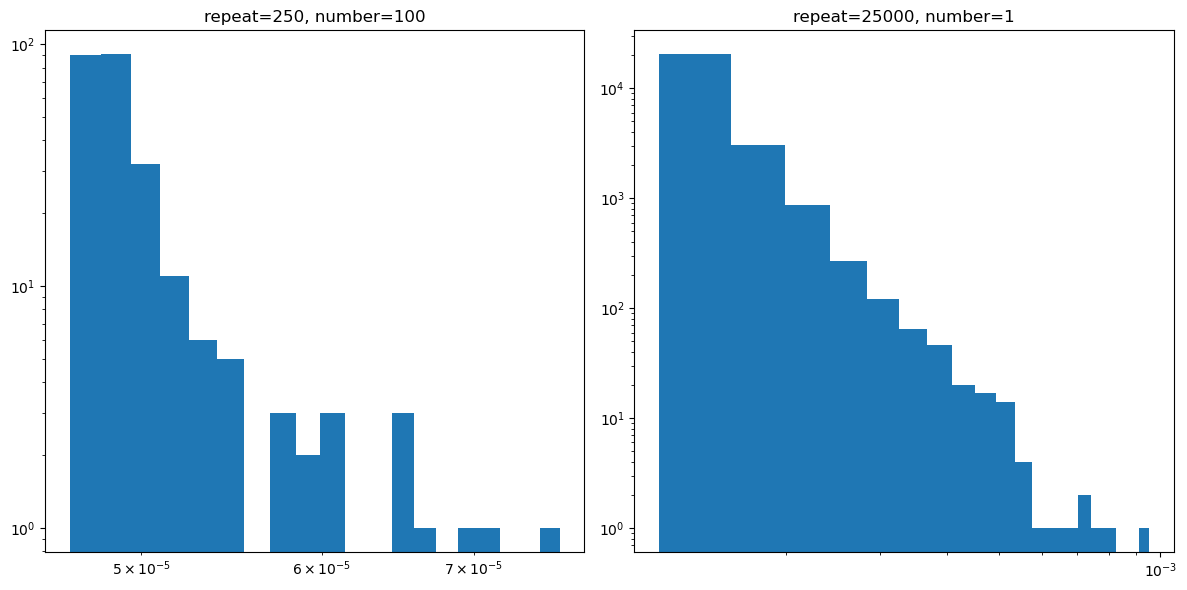

In [88]:
benchmark(square_matrix, create_init_function, 500, 500)

repeat=250, number=100: 0.00019305623000036575 - 0.0002908343600029184
repeat=25000, number=1: 0.0005376740000428981 - 0.002263262999804283


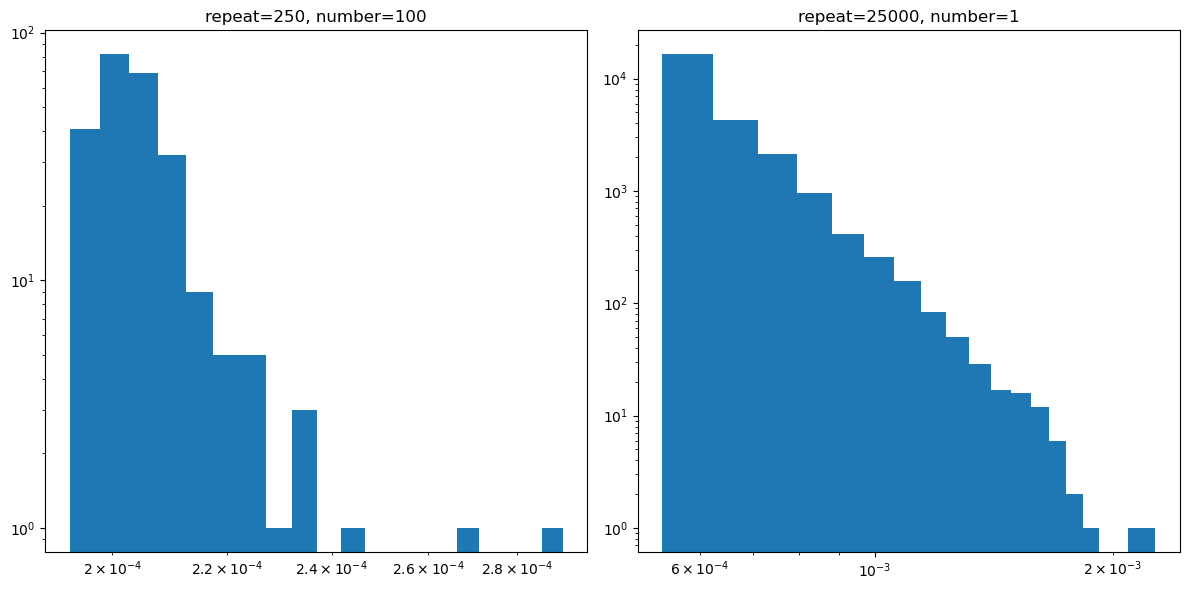

In [89]:
benchmark(square_matrix, create_init_function, 1_000, 1_000)

repeat=250, number=100: 0.0023876798699984645 - 0.00434326331000193
repeat=25000, number=1: 0.0025266470001952257 - 0.016366818999813404


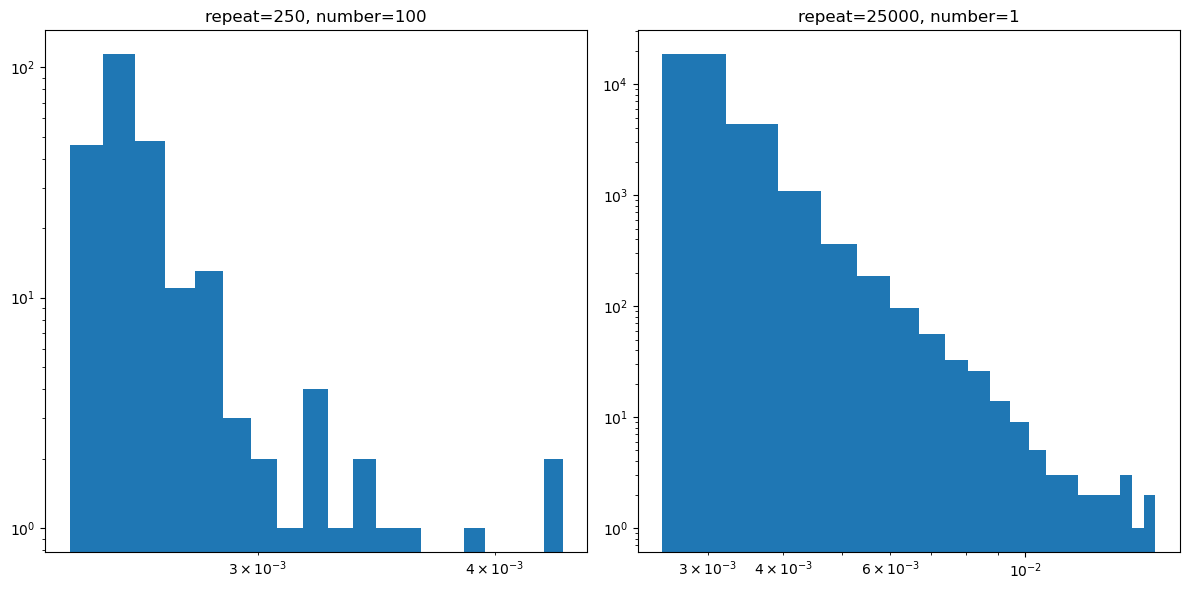

In [90]:
benchmark(square_matrix, create_init_function, 2_000, 2_000)

As the last benchmark shows, times are getting closer together for both types of benchmarks.

Now you might wonder which benchmark is correct?  It depends on how you intend to use `square_matrix(...)`.
* If you intend to call `square_matrix` repeatedly on the same 2D array, the first benchmark with `number` much larger than 1 is the correct one, since it takes into account the use of the caches of your CPU.
* If you intend to call `square_matrix` once on many different 2D arrays, the second benchmark is the relevant one as it computes the square of each matrix exactly once, so much less cache reuse will happen.

## All numbers are equal...

but som are more equal than others.

Consider the following 2D arrays:

In [137]:
rows, cols = 1_000, 1_000
power = 100
A = np.ones((rows, cols))
B = 0.9999999*np.ones((rows, cols))
C = np.zeros((rows, cols))
D = 1.0e-50*np.ones((rows, cols))

All have identical shape and dtype.  Now consider the folloing timing results.

In [138]:
%timeit A**power

2.35 ms ± 37 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [139]:
%timeit B**power

2.27 ms ± 52.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [140]:
%timeit C**power

8.02 ms ± 76.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [141]:
%timeit D**power

38.9 ms ± 187 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Note:** the numbers may be qualitatively different depending on the CPU brand your computation runs on.

On current Intel CPUs, the way to handle denormalized floating point values is very slow.  This shows for array `C`, but especially for array `D`.  As the powers are computed, for array `D`, the values quickly tend to 0.  However, the CPU tries to retain a level of precision so as not have have a hard cutoff between non-zero and zero values by no longer normalizing the floating point representation.  Computations of denormalized floating point values on Intel hardware are notoriously slow.

For more information, see the [Wikipedia entry](https://en.wikipedia.org/wiki/Subnormal_number) on denormalized (or subnormal) numbers.